# Example: Simulating a System of Autonomous Trading Agents
In this example, we're looking at a system of self-governing trading agents positioned in a grid world. Each agent decides whether to buy, hold, or sell shares based on a set rule (also known as a policy) and the behaviors of their neighboring agents. Depending on their neighbors' actions, the agents make their own decisions for the next turn. Taking this a step further, we'll then explore the inverse problem where an agent doesn't know the rule and instead needs to learn it by observing the actions of their neighbors.

## Learning objectives
* __Prerequisites__: In this section, we set several constants that we'll use in the other tasks in this example.
* __Task 1__: In this task, we build a model of the rule the agent uses to choose an action, i.e., we use the known rule to generate testing data, which we then use to reverse-engineer the rule in the last task.
* __Task 2__: In this task, we will utilize the policy model instance created in the previous task to simulate the evolution of the agent's state. This will generate valuable simulation data on its own, which we will also use as training data in the next task to learn the rule.
* __Task 3__: In this task, we will utilize simulation data to study how agents make decisions. Specifically, we aim to learn the rule, i.e., a policy that links the environment an agent perceives to the next action an agent chooses. To achieve this, we will employ reinforcement learning, particularly a Q-learning approach, to train a learning agent to replicate the decision-making process of agents in the simulation.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [3]:
include("Include.jl");

## Prerequisites: Problem setup and constants
In this section, we set several constants that we'll use in the other tasks in this example. The comment beside each value describes the constant and permissible values. Let's begin with constants associated with the rule and the world and conclude by calculating the number of possible rules.

In [5]:
rule_index = 6158; # the Wolfram rule index, see below for the range of possible values. Default: 1635
number_of_colors = 3; # each the number of colors, i.e., the number of possible states for each agent. 
radius = 4; # size of the neighborhood an agent looks at. DO NOT CHANGE
number_of_rows = 2^8; # number of rows in the 2D agent grid. Default: 256. Larger values will **slow down** the computation below
number_of_columns = 2^8; # number of cols in the 2D agent grid. Default: 256. Larger values will **slow down** the computation below
number_of_agents = number_of_rows*number_of_columns; # the number of agents in the grid
middle = (number_of_rows / 2) |> Int; # the index of the middle agent (we have a square grid by default, so middle x = middle y)
number_of_iterations = 2^10; # the number of turns we simulate the system for. Default: 1024 turns
agent_view_width = 15; # ± this value from a center point will be used for plotting
agent_train_width = 150; # ± this value from a center point will be used for training

Next, let's set constants related to viewing and analyzing the simulation results below.

In [7]:
î,ĵ = 10,middle # agent location to view. This can be any value î ∈ 2:number_of_rows-1 and ĵ ∈ 2:number_of_cols-1
turn_index_to_view = 600; # turn to view in plots and training
view_period =  range(turn_index_to_view - agent_view_width, stop=turn_index_to_view+agent_view_width,step=1) |> collect; # plot range
train_period = range(turn_index_to_view - agent_train_width, stop=turn_index_to_view+agent_train_width,step=1) |> collect; # train range

### Curious: How many totalistic policies exist?
Finally, before we get to the tasks below, let's answer a question that most students have: for this configuration, i.e., number of colors and neighborhood size (radius), how many `number_of_colors` totalistic rules are possible?

In [9]:
number_of_states = range(0, stop = (number_of_colors - 1), step = (1/radius)) |> length;
total_number_policies = [(number_of_colors - 1)*(number_of_colors^(i-1)) for i ∈ 1:number_of_states] |> sum
println("For $(number_of_colors) colors with a radius = $(radius), the number of totalistic rules: $(total_number_policies + 1)")

For 3 colors with a radius = 4, the number of totalistic rules: 19683


## Task 1: Build a Totalistic Wolfram Policy Model
In this task, we build a model of the rule (also called a `policy`) that the agent uses to choose an action, i.e., we use the known rule to generate testing data, which we then use to reverse-engineer the rule in the last task. Let's get started!
* We instantiate [an instance of the `MyTwoDimensionalTotalisticWolframRuleModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel) using a [cutom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTwoDimensionalTotalisticWolframRuleModel},%20NamedTuple}) and explore its fields. The [`MyTwoDimensionalTotalisticWolframRuleModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel) holds data associated with the simulation rule. We'll store the [populated `MyTwoDimensionalTotalisticWolframRuleModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel) in the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` variable. 
* To create the rule model, pass the type of the model that we want to create, i.e., [`MyTwoDimensionalTotalisticWolframRuleModel`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel) and argument data organized in a [Julia NamedTuple instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) to the [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTwoDimensionalTotalisticWolframRuleModel},%20NamedTuple}). This type requires a value for the `rule_index::Int64`, the number of colors in the `colors::Int64` field and the `radius::Int64`.

In [11]:
policy_model = build(MyTwoDimensionalTotalisticWolframRuleModel, (
    index = rule_index,
    colors = number_of_colors,
    radius = radius,
));

The populated rule model stored in the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` has (in addition to the fields above) two critical fields that are populated by the [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTwoDimensionalTotalisticWolframRuleModel},%20NamedTuple}), namely the `rule::Dict{Int64, Int64}` field, and the `neighborhoodstatesmap::Dict{Float64, Int64}` field.
* The `rule::Dict{Int64, Int64}` dictionary holds the mapping between the state index of a neighborhood and the next state of the agent. The `key` of the dictionary is the neighborhood state index, and the `value` is the _next state_ of the agent. For example, there are `number_of_states::Int64` possible neighborhood configurations, e.g., given the default values for the `radius::Int64` and `number_of_colors::Int64` `number_of_states = 9`. These configurations are numbered starting from zero, i.e., `0...8`.
* These values then point to the agent's _next state_. For example, neighborhood configuration `4` in the current turn results in the agent being in `s = 2` in the simulation's _next_ turn.

In [13]:
number_of_states = policy_model.rule |> length
policy_model.rule

Dict{Int64, Int64} with 9 entries:
  0 => 2
  4 => 1
  5 => 1
  6 => 2
  2 => 0
  7 => 2
  8 => 0
  3 => 0
  1 => 0

* The `neighborhoodstatesmap::Dict{Float64, Int64}` dictionary maps the continuous value of a [Wolfram totalistic rule](https://mathworld.wolfram.com/TotalisticCellularAutomaton.html) with the index of the neighborhood of an agent. Suppose we denote the neighborhood of an agent as $\mathcal{N}$, where the radius is denoted as $\dim\mathcal{N}$. The current state of the neighborhood $\mathcal{N}$ at time $t$ is the average state of the cells in $\mathcal{N}$:
$$
\bar{S}(t) = \frac{1}{\dim\mathcal{N}}\cdot\sum_{j\in\mathcal{N}}s_{j}(t)
$$
where $s_{j}(t)\in\mathcal{N}$ is the state of the jth element of the neighborhood at time $t$. We know that $s$ is an integer; thus, $\bar{S}(t)$ could be a decimal number. To map between the values of $\bar{S}(t)$ and possible configurations, we enumerate the possible quanta of $\bar{S}(t)$. For instance, for a `radius::Int64 = 4` and `number_of_colors = 3` system, the states $s$ will be in the set $s\in\left\{0,1,2\right\}$. This means 
$\bar{S}(t)$ will be in quanta of `1/radius`, starting at zero:

In [15]:
policy_model.neighborhoodstatesmap

Dict{Float64, Int64} with 9 entries:
  0.0  => 0
  1.25 => 5
  0.5  => 2
  2.0  => 8
  1.5  => 6
  1.75 => 7
  0.25 => 1
  0.75 => 3
  1.0  => 4

* The keys in the `neighborhoodstatesmap::Dict{Float64, Int64}` dictionary are the $\bar{S}(t)$ values, while the values are the index of that configuration. For example, $\bar{S}(t)$ = `1.5` corresponds to a neighborhood configuration index of `6`. The neighborhood configuration index, in combination with the `rule::Dict{Int64, Int64}` dictionary, determines the _next state_ of the agent; for example, using the default value of `rule_index = 1635`, if the neighborhood of an agent is in configuration `6`, the agent's next state will be `s = 2.`

## Task 2: Simulate a Grid World using our Wolfram Policy Model
In this task, we'll use the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` instance created in the previous task to simulate the evolution of the agent's state [using the `solve(...)` method exported by the `VLQuantitativeFinancePackage.jl` package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}). This will produce simulation data which is interesting in its own right, which can serve as training data, that we'll use in the last task, to learn the rule. Let's go!

### TODO: Setup the initial state of the agents
First, let's start by setting up the `initialstate::Array{Int64,2}` array. The `initialstate::Array{Int64,2}` array is a `number_of_rows`$\times$`number_of_cols` array holding the initial state of each agent at `t = 0`. Each element of the `initialstate::Array{Int64,2}` array is the state $s_{ij}$ for the agent at element `(i,j),` where $s_{ij}\in$`{0...number_of_colors-1}.`
* The default `initialstate::Array{Int64,2}` array has `1's` everywhere _except_ the four corners and edge midpoints, which take on values of `0`. We populate the `initialstate::Array{Int64,2}` array using [nested `for-loops`](https://docs.julialang.org/en/v1/base/base/#for), where we iterate over the rows in the outer-loop (index `row`) and the columns (index `col`) in the inner-loop.
* For each `(row, col),` we check if we are at a corner or edge midpoint using [compound `if` statements](https://docs.julialang.org/en/v1/base/base/#if). If yes, we set the initial element state to `0`; otherwise, we set the initial agent state to `1.`

In [19]:
initialstate = Array{Int64,2}(undef, number_of_rows, number_of_columns);
for row ∈ 1:number_of_rows
    for column ∈ 1:number_of_columns
        if (row == 1 && column == number_of_columns)
            initialstate[row, column] = 0;
        elseif (row == middle && column == middle)
            initialstate[row, column] = 0;
        elseif (row == number_of_rows && column == 1)
            initialstate[row, column] = 0;
        elseif (row == number_of_rows && column == number_of_columns)
            initialstate[row, column] = 0;
        elseif (row == 1 && column == 1)
            initialstate[row, column] = 0;
        elseif (row == middle && column == 1)
            initialstate[row, column] = 0;
        elseif (row == 1 && column == middle)
            initialstate[row, column] = 0;
        elseif (row == middle && column == number_of_columns)
            initialstate[row, column] = 0;
        elseif (row == number_of_rows && column == middle)
            initialstate[row, column] = 0;
        else
            initialstate[row, column] = 1;
        end
    end
end

### TODO: Run the simulation
We simulate the evolution of the agents in the grid world specified in the `initialstate::Array{Int64,2}` array for the rule described in the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` instance, [using the `solve(...)` method exported by the `VLQuantitativeFinancePackage.jl` package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}).
* The [`solve(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}) takes three arguments: the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` instance, the `initialstate::Array{Int64,2}` of the square population of agents, and the number of turns to simulate in the `steps::Int64` argument.
* The [`solve(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}) returns the `frames::Dict{Int64, Array{Int64,2}}` dictionary which holds the state of the system, encoded as a `number_of_rows`$\times$`number_of_cols` array holding the agent state $s_{ij}$ values, for each turn, starting at `0` up to `number_of_iterations.` The keys of the `frames::Dict{Int64, Array{Int64,2}}` dictionary are the time index, while the values are frames of the system at that time index.

In [21]:
frames = solve(policy_model, initialstate, steps = number_of_iterations);

To access the state of the system, i.e., the states of each agent in the grid world, we pass the turn index to the `frames::Dict{Int64, Array{Int64,2}}` dictionary, which returns the state frame. For example, we show the state of all agents at `turn_index_to_view::Int64` in the `myframe::Array{Int64,2}` variable:

In [23]:
myframe = frames[turn_index_to_view]

256×256 Matrix{Int64}:
 0  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  1
 1  0  1  2  1  0  2  0  2  0  1  0  0     1  1  1  0  2  0  2  2  2  0  0  1
 1  0  2  0  2  0  0  2  2  0  0  2  0     1  1  0  1  0  2  2  2  0  2  0  1
 1  0  1  2  1  0  2  2  0  0  1  0  1     0  0  2  0  0  1  2  0  2  0  0  1
 1  0  0  0  0  2  1  2  1  0  2  2  0  …  2  1  2  1  1  2  0  2  0  2  0  1
 1  0  2  0  2  1  2  0  0  2  1  0  2     1  2  1  2  0  0  2  0  0  0  0  1
 1  0  0  2  2  2  0  0  2  0  2  2  0     2  0  0  1  0  0  0  0  0  0  0  1
 1  0  2  2  0  1  0  2  1  0  0  2  0     0  0  0  1  2  0  0  0  1  1  0  1
 1  0  0  0  0  0  2  0  0  0  0  1  2     0  0  0  1  0  1  0  1  1  0  0  1
 1  0  1  0  1  2  1  2  0  0  2  0  2  …  0  0  0  0  1  0  1  0  1  1  0  1
 1  0  0  2  0  2  0  2  2  1  0  1  0     2  2  1  1  0  1  0  1  0  0  0  1
 1  0  0  0  1  0  2  0  0  2  2  0  1   

The data in the `myframe::Array{Int64,2}` variable is a snapshot of the system state, i.e., the state each agent is in at this turn in the simulation. However, looking at a block of [Int values](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/#Integers-and-Floating-Point-Numbers) may not be super informative, so let's develop of some other ways to visualize how the agents in the grid world are making decisions as a function of time.

### TODO: Visualize the simulation results
Let's visualize the data in the `myframe::Array{Int64,2}` variable [using the `display(...)` method exported by the Images.jl package](https://github.com/JuliaImages/Images.jl). First, we'll construct the `my_color_dictionary::Dict{Int64, RGB}` dictionary, which maps the agent state values, e.g., $s\in\left\{0,1,2\right\}$ for a `number_of_colors = 3` system, to an [RGB color type exported by the Colors.jl package](https://github.com/JuliaGraphics/Colors.jl).
* The keys of the `my_color_dictionary::Dict{Int64, RGB}` dictionary are the states, e.g., $s\in\left\{0,1,2\right\}$ while the values correspond to colors associated with those states. Here, we use the [`colorant` shortcut syntax exported by Colors.jl](https://juliagraphics.github.io/Colors.jl/stable/constructionandconversion/#Color-Parsing) to create instances of [named colors provided by Colors.jl](https://juliagraphics.github.io/Colors.jl/stable/namedcolors/). By default, we map the buy state (`s = 0`) to `lightgreen,` the hold state (`s = 1`) to `white`, and the sell state (`s = 2`) to `red.` Students can change this mapping to whatever they want!

In [26]:
my_color_dictionary = Dict{Int64, RGB}();
my_color_dictionary[0] = colorant"lightgreen"; # 0: buy state
my_color_dictionary[1] = colorant"white";      # 1: hold state
my_color_dictionary[2] = colorant"red";        # 2: sell state

`Unhide` the code block below to see how we mapped the agent state held by the `myframe::Array{Int64,2}` array to the colors held in the `my_color_dictionary::Dict{Int64, RGB}` dictionary and visualized it [using the `display(...)` method exported by the Images.jl package](https://github.com/JuliaImages/Images.jl).

#### Summary
* The agents' states appear well-mixed in the grid world for the default choices of `turn_index_to_view = 600` and `rule_index = 1635`. Each red pixel denotes an agent in the `sell` state, each green pixel is an agent in the `buy` state, and white pixels denote agents in the hold state during this simulation turn. There appears to be symmetric microstructure along the main diagonal, i.e., local non-random agent communities making structured, i.e., correlated decisions.
* The state of the agents in the frame will change as students change the value for the `turn_index_to_view::Int64` variable (or the `rule_index::Int64` value), i.e., we look at a different turn or rule. For early values of the `turn_index_to_view::Int64` variable, interesting patterns develop, while as the `turn_index_to_view::Int64` becomes larger, the system settles into the well-mixed pattern shown below.
* The fraction of agents in the buy state (light green) and the sell state (red) appear to be approximately equal, with the hold state (white) being less prominent. We'll dig into the fraction of each state below.

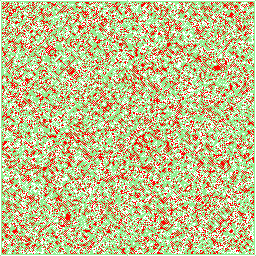

In [28]:
let
    new_display_frame = Array{RGB,2}(undef, number_of_rows, number_of_columns);
    for j ∈ 1:number_of_rows
        for k ∈ 1:number_of_columns
            new_display_frame[j,k] = myframe[j,k] |> s -> my_color_dictionary[s];
        end
    end
    display(new_display_frame)
end

### Check: Is the simulation producing the correct next states?
Before we move on to the next task, let's take a step back and answer a simple question: is the logic [encoded in the `solve(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}) correct, i.e., can we validate the rule in the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` by observing the data in the simulation frames? 
* To start, let's build the `moves_dictionary::Dict{Int64, Tuple{Int64, Int64}}` dictionary, which we use to enumerate the neighborhood of an agent. The keys of this dictionary are move indexes (`1,2,3,4`), while the values are the coordinate changes $\Delta$ associated with the move, where  $\left(i,j\right)\leftarrow\left(i,j\right) + \Delta$. For example, `key = 2` points to the `Δ = (1,0)` transformation, which is the `down` transformation (we increase the row index by `1`).

In [30]:
moves_dictionary = Dict(
    1 => (-1,0), # up
    2 => (1,0),  # down
    3 => (0,-1), # left
    4 => (0,1),  # right
);

Now we use the `moves_dictionary::Dict{Int64, Tuple{Int64, Int64}}` dictionary to populate the `in_sample_dataset::Dict{Int64, Array{Int64,1}}` dictionary, which holds the neighborhood states and next state, encoded as a `data::Array{Int64,1}` array, for agent $(i,j)$. The keys of the `in_sample_dataset::Dict{Int64, Array{Int64,1}}` dictionary hold the turn index, while the value is the populated data array `[neighborhood ... | next state]` for that turn.
* First, we iterate over the turns of the simulation and access the current frame at `p,` which we save in the `my_current_frame::Array{Int64,2}` variable, and the next frame at index `p+1`, which we save in the `my_next_frame::Array{Int64,2}` variable.
* For the current frame, we calculate the neighborhood using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for), where we iterate over the `moves_dictionary::Dict{Int64, Tuple{Int64, Int64}}` dictionary, calculate each neighbor of the current state and save that in the `data::Array{Int64,2}` array, and then add the _next state_ for this agent to the last element of the `data::Array{Int64,2}` array. Finally, we store the populated data array `[neighborhood ... | next state]` in the `in_sample_dataset::Dict{Int64, Array{Int64,1}}` dictionary.

In [32]:
in_sample_dataset = Dict{Int64, Array{Int64,1}}();
N = length(train_period);
for p ∈ 1:(N - 1)  
    
    my_current_frame = train_period[p] |> t-> frames[t];
    my_next_frame = train_period[p+1] |> t-> frames[t];
    
    data = Array{Int64,1}(undef, radius+1)
    for k ∈ 1:radius
        Δ = moves_dictionary[k];
        i,j = î + Δ[1], ĵ + Δ[2];        
        data[k] = my_current_frame[i,j];
    end
    data[radius + 1] = my_next_frame[î,ĵ]; # reminder: the rule gives us the *next* state    
    in_sample_dataset[p] = data; 
end

In [33]:
in_sample_dataset

Dict{Int64, Vector{Int64}} with 300 entries:
  56  => [2, 2, 0, 2, 2]
  35  => [2, 0, 0, 0, 0]
  60  => [0, 0, 0, 0, 2]
  220 => [2, 0, 2, 2, 2]
  67  => [0, 2, 2, 0, 1]
  215 => [2, 2, 2, 0, 2]
  73  => [2, 0, 0, 2, 1]
  251 => [0, 0, 0, 0, 2]
  115 => [0, 1, 0, 1, 0]
  112 => [0, 1, 0, 0, 0]
  185 => [0, 0, 1, 0, 0]
  86  => [0, 0, 1, 0, 0]
  168 => [1, 0, 2, 2, 1]
  207 => [1, 1, 1, 1, 1]
  263 => [0, 0, 2, 0, 0]
  242 => [2, 2, 2, 2, 0]
  183 => [1, 1, 2, 1, 1]
  224 => [0, 0, 0, 2, 0]
  177 => [0, 0, 1, 0, 0]
  12  => [0, 0, 0, 0, 2]
  75  => [1, 1, 0, 1, 0]
  23  => [1, 0, 0, 1, 0]
  111 => [0, 0, 0, 0, 2]
  264 => [1, 2, 2, 1, 2]
  41  => [0, 0, 0, 0, 2]
  ⋮   => ⋮

Finally, let's check the recorded next state, encoded in the last element of each `data::Array{Int64,1}` array, against the value of the next state computed using the first `1...radius` neighbors of each `data::Array{Int64,1}` array. We store the actual next state in the `s::Int64` variable and the computed next state in the `ŝ::Int64` variable.
* `Hypothesis`: If the [`solve(...)` method implementation logic](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}) is correct, the observed and computed next states should be equal, i.e., `s = ŝ`. We test the equality using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert); if this test fails, [an AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) indicating there is some issue with the [`solve(...)` method implementation logic](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}})
* `Unihide` the code block below to see how we computed the next state `s.` In particular, we compute the $\bar{S}(t)$ value, use the `neighborhoodstatesmap::Dict{Float64, Int64}` dictionary to find the neighborhood configuration index, and the `rule::Dict{Int64, Int64}` dictionary on the `policy_model` instance to lookup the next state value.

In [35]:
let
    Q = policy_model.neighborhoodstatesmap;
    R = policy_model.rule;
    N = length(train_period);
    for p ∈ 1:(N - 1)
        
        data = in_sample_dataset[p];
        s = Q[round(mean(data[1:radius]), digits=2)] |> j -> R[j] # actual *next* state s
        ŝ = data[end]; # predicted *next* state ŝ
    
        @assert s == ŝ # Are the actual and simulated *next* states the same?
    end
end

### TODO: Visualize the average state dynamics of the three-color world
Now that we have validated the simulation logic let's continue with the visualization and analysis of the simulation results. First, let's return to the overall representation of states in our population of agents, i.e., the fraction of buy, sell, and hold agents. To explore this question, we compute the `average_state_array::Array{Float64,2}` array, which holds the overall fraction of each agent state for each turn in the simulation.
* First, we declare the `average_state_array::Array{Float64,2}` array, which is a `number_of_iterations`$\times$`number_of_colors` array of `Float64` values, where each element of the array is the fraction of agents in the population that are in the state `s` at turn index `i`. The rows of the `average_state_array::Array{Float64,2}` array hold the turns, while each column corresponds to a state fraction.
* We iterate over the turns in the simulation ([the outer `for-loop`](https://docs.julialang.org/en/v1/base/base/#for)) , access each simulation frame from the `frames::Dict{Int64, Array{Int64,2}}` dictionary, and then compute the fraction of agents in state `s` by iterating over the states ([the inner `for-loop`](https://docs.julialang.org/en/v1/base/base/#for)), finding all agents in state `s` [using the Julia `findall(...)` function](https://docs.julialang.org/en/v1/base/arrays/#Base.findall-Tuple{Any}), compute the number of agents in state `s` [using the Julia `length(...)` function](https://docs.julialang.org/en/v1/base/arrays/#Base.length-Tuple{AbstractArray}), and the computing the fraction of agents in state `s` by dividing by the `number_of_agents`.
* The calculation logic has been condensed into `1-line` by making use of the [Julia pipe `|>` operator, which is a super convenient tool for function composition](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We use this pattern a lot!

In [37]:
average_state_array = Array{Float64,2}(undef, number_of_iterations, number_of_colors)
for i ∈ 0:(number_of_iterations - 1)
    myframe = frames[i];
    for s ∈ 1:number_of_colors
        average_state_array[i+1,s] = findall(x -> x == s-1, myframe) |> length |> len -> (len/number_of_agents)
    end
end
average_state_array;

#### Summary
`Unhide` the code block below to see how we plotted the data in the `average_state_array::Array{Float64,2}` array. The average state data will depend upon the choice of `rule_index::Int64.` Let's consider the default value of `1635.`
* The simulation results for `rule_index = 1635` and the default value of the `initialstate::Array{Int64,2}` array suggests that after some _warmup time_ (in this case approximately 250 turns), `rule_index = 1635` produces an equilibrium system in the sense that the overall fractions of buy, sell and hold agents are approximately constant. As discussed in our initial analysis above, the fraction of sell and buy states are similar, with the fraction of hold being less than buy and sell. However, the sell state appears to be a larger fraction than the buy.
* A common misconception when considering the system equilibrium is that the agents are not changing their state. This is _not true_. Instead, this equilibrium indicates that the overall fractions are approximately constant, but the state of each agent may change. Let's explore this idea by looking at the neighborhood and next states for a specific agent.

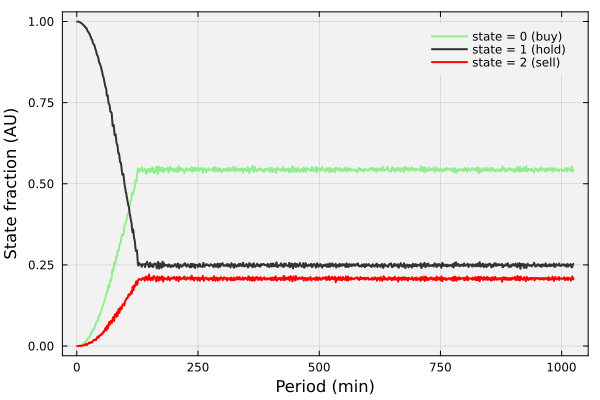

In [39]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    color_dictionary = Dict(0 =>:lightgreen, 1=>:gray20, 2=>:red);
    color_label_dictionary = Dict(0 => "buy", 1 => "hold", 2 => "sell");
    for s ∈ 1:number_of_colors
        plot!(q, average_state_array[:,s], label="state = $(s-1) ($(color_label_dictionary[s-1]))", 
            lw=2, c=color_dictionary[s-1])
    end
    current()
    xlabel!("Period (min)", fontsize=18)
    ylabel!("State fraction (AU)", fontsize=18)
end

#### Summary
`Unhide` the code block below to see how we compute and plot the neighborhood configuration of a particular agent in the system for a time window centered on the `turn_index_to_view::Int64` turn (the range shown is from the `view_period::Array{Int64,1}` array). The `(î,ĵ)` coordinates specified in the __Prerequisites__ section specify the chosen agent. 
* The state of the neighborhood surrounding the selected agent varies over several configurations, but _not all possible configurations_. For example, the agent never sees (at least in this window of turns) state `1`, visits state `0` once, and states `2, 5, 6` and `7` only a few times. Let's quantify how often the agent sees a particular neighborhood configuration.

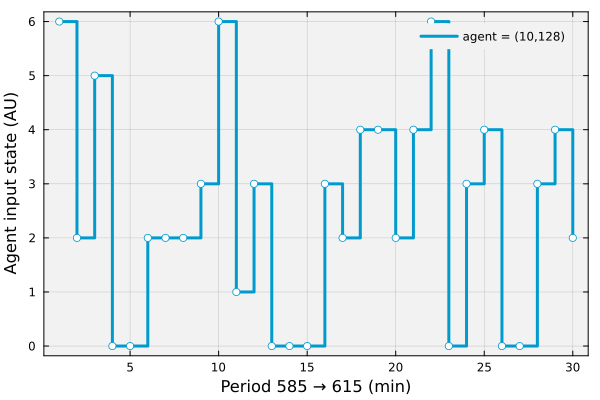

In [41]:
let
    neighborhood_state_array = Array{Int64,1}();
    Q = policy_model.neighborhoodstatesmap;
    N = length(view_period);
    
    view_sample_dataset = Dict{Int64, Array{Int64,1}}();
    for p ∈ 1:(N - 1)
        my_current_frame = view_period[p] |> t-> frames[t];
        my_next_frame = view_period[p+1] |> t-> frames[t];
    
        data = Array{Int64,1}(undef, radius+1)
        for k ∈ 1:radius
            Δ = moves_dictionary[k];
            i,j = î + Δ[1], ĵ + Δ[2];        
            data[k] = my_current_frame[i,j];
        end
        data[radius + 1] = my_next_frame[î,ĵ]; # reminder: the rule gives us the *next* state    
        view_sample_dataset[p] = data;    
    end
    
    
    for p ∈ 1:(N - 1)
        data = view_sample_dataset[p];
        j = Q[round(mean(data[1:radius]), digits=2)]; # index in rule
        push!(neighborhood_state_array,j);
    end
    
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, neighborhood_state_array, linetype=:steppost, lw=3, c=:deepskyblue3, label="agent = ($(î),$(ĵ))")
    scatter!(neighborhood_state_array, label="", c=:white, msc=:deepskyblue3)
    xlabel!("Period $(first(view_period)) → $(last(view_period)) (min)", fontsize=18)
    ylabel!("Agent input state (AU)", fontsize=18)
end

`Unhide` the code block to see how we quantified how often an agent sees a particular neighborhood configuration using [the `pretty_table(...)` function exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl). For the frequency calculation below, we used a wider window of turns compared to the plot above, but we are still centered on `turn_index_to_view::Int64.` The `train_period::Array{Int64,1}` array specifies the simulation turn range used to calculate the visited neighborhood frequency. 
* The selected agent, for the `train_period::Array{Int64,1}` window of turns, sees configuration `4` most often, with configuration `6` being the second most often viewed. Configurations `2, 5,` and `8` are tied for third place. Finally, the least visited turn is neighborhood configuration `1`.
* __Consider__: If we observe a selected agent to understand how it makes decisions, the lack of exposure to specific neighborhood configurations could impact our ability to grasp its decision-making process. Do you think this intuition makes sense?

In [43]:
let

    neighborhood_state_array = Array{Int64,1}();
    Q = policy_model.neighborhoodstatesmap;
    N = length(train_period);
    for p ∈ 1:(N - 1)
        data = in_sample_dataset[p];
        j = Q[round(mean(data[1:radius]), digits=2)]; # index in rule
        push!(neighborhood_state_array,j);
    end

    neighborhood_freq_dict = Dict{Int64,Float64}()
    for s ∈ 0:(number_of_states - 1)
        neighborhood_freq_dict[s] = findall(x-> x == s, neighborhood_state_array) |> length |> x-> x/(N-1)
    end

    table_df = DataFrame()
    for s ∈ 0:(number_of_states - 1)
        row_data = (
            state = s,
            frequency = neighborhood_freq_dict[s]
        );
        push!(table_df, row_data);
    end
    pretty_table(table_df)
end

┌───────┬────────────┐
│ state │  frequency │
│ Int64 │    Float64 │
├───────┼────────────┤
│     0 │   0.183333 │
│     1 │   0.126667 │
│     2 │   0.226667 │
│     3 │   0.106667 │
│     4 │   0.186667 │
│     5 │  0.0766667 │
│     6 │  0.0666667 │
│     7 │ 0.00666667 │
│     8 │       0.02 │
└───────┴────────────┘


`Unhide` the code block below to see how we plotted the next state value for the selected agent in the `view_period::Array{Int64,1}` array of simulation turns.
* The selected agent samples all possible states, i.e.,  `{0 = buy, 1 = hold, 2 = sell}` in no particular regular pattern during the view window. Can you verify (on your own) that the observed next states are consistent with the observed neighborhood configurations using the `rule::Dict{Int64, Int64}` dictionary?

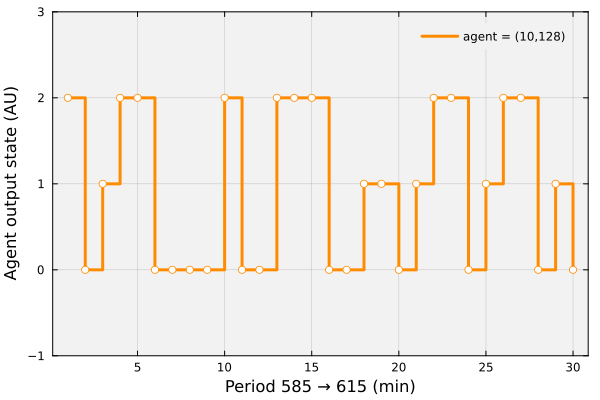

In [45]:
let

    N = length(view_period);
    
    view_sample_dataset = Dict{Int64, Array{Int64,1}}();
    for p ∈ 1:(N - 1)
        my_current_frame = view_period[p] |> t-> frames[t];
        my_next_frame = view_period[p+1] |> t-> frames[t];
    
        data = Array{Int64,1}(undef, radius+1)
        for k ∈ 1:radius
            Δ = moves_dictionary[k];
            i,j = î + Δ[1], ĵ + Δ[2];        
            data[k] = my_current_frame[i,j];
        end
        data[radius + 1] = my_next_frame[î,ĵ]; # reminder: the rule gives us the *next* state    
        view_sample_dataset[p] = data;    
    end
    
    next_state_array = Array{Int64,1}();
    for p ∈ 1:(N - 1)
        data = view_sample_dataset[p];
        push!(next_state_array, data[end]);
    end
    
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, next_state_array, ylims=(-1,3), linetype=:steppost, c=:darkorange, lw=3, label="agent = ($(î),$(ĵ))")
    scatter!(next_state_array, label="", c=:white, msc=:darkorange)
    xlabel!("Period $(first(view_period)) → $(last(view_period)) (min)", fontsize=18)
    ylabel!("Agent output state (AU)", fontsize=18)
end

## Task 3: Learn the policy function by observing agent choices
In this task, we will utilize simulation data to study how agents make decisions. Specifically, we aim to learn the rule, i.e., a policy that links the environment an agent perceives to the next action an agent chooses. To achieve this, we will employ reinforcement learning, particularly a Q-learning approach, to train a learning agent to replicate the decision-making process of agents in the simulation. Similar to [the bandit problem we explored previously](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#Bandit-Problems), let's start by formulating a `myworld(...)` function and some models of the world and the learning agent. Let's go!

### TODO: Specify the `myworld` function
The `myworld(...)` function takes a grid world model, [enoded as a `MyWolframGridWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframGridWorldModel), the turn index `t::Int64`, the current neighborhood configuration `s::Int64` and the proposed action `a::Int64`, i.e., the value of the _next agent state_ as arguments and returns a [Julia `Tuple` instance](https://docs.julialang.org/en/v1/manual/functions/#Tuples) holding the _observed next neigborhhod_ and the reward for being in the neighborhood `s` and transitioning to state `a`, i.e.., for taking action `a.` 
* __Reward__:The agent is provided with the world `model,` the turn index `t,` the state `s` (the current neighborhood configuration), and the action `a,` which is the agent's prediction of the choice for the next turn, whether it's to `{buy, hold, sell}.` Using the training data held in the `model` and the current time step `t,` we can determine the actual next action. We then compare the agent's prediction (encoded in `a`) with the actual value (encoded as `a′`). If they match, the agent receives a reward of `+1.1`; if they don't match, the agent receives a penalty of `-1.0`.
* __Next state__: Here, we assume that we know the playback frames completely; thus, we know the _next neighborhood configuration_. We get this value from the dataset. We pass the next configuration `s′` and the reward `r` back to the caller.

In [48]:
function myworld(model::MyWolframGridWorldModel, t::Int, s::Int, a::Int)::Tuple{Int, Float64}
    
    # initialize -
    s′ = nothing
    r = nothing
    
    # grab the parameters from the model -
    dataset = model.data;
    policymap = model.policymap;

    # compute the reward
    data = dataset[t]; # get data for turn = [neighborhood ... | next state]
    a′ = data[end]+1; # the last element is the next action (correct for zero)
    if (a′ == a) 
        r = 1.1;  # the agent got the next state correct
    else
        r = -1.0; # ooops. Wrong!
    end

    # get the next configuration - this assumes we have full knowledge of the playback frames
    next_state_data = dataset[t+1];
    my_neighbors = next_state_data[1:end-1];
    s′ = round(mean(my_neighbors), digits=2) |> value -> policymap[value] + 1; # correct for zero

    # return -
    return (s′,r);
end;

### TODO: Formulate the grid world model
Next, we build [a `MyWolframGridWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframGridWorldModel), using a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyWolframGridWorldModel},%20NamedTuple}). The [`MyWolframGridWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframGridWorldModel) holds data and functions associated with the simulation world. We save the world model in the `worlfram_gridworld_model::MyWolframGridWorldModel` variable.
* The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyWolframGridWorldModel},%20NamedTuple}) takes the type of model we want to build, i.e., [`MyWolframGridWorldModel`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframGridWorldModel), and a [Julia `NamedTuple` instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) holding the required data fields; the `number_of_states::Int64` (number of neighborhood configurations), the `data::Dict{Int64, Array{Int64,1}}` field holds the training data the agent will learn from, the `policymap::Dict{Float64, Int64}` fields holds the `neighborhoodstatesmap::Dict{Float64, Int64}` dictionary, i.e., the map between $\bar{S}(t)$ and the neighborhood configuration indexes and the `world` function (the  `myworld(...)` function defined above). 

In [50]:
worlfram_gridworld_model = build(MyWolframGridWorldModel, (
    number_of_states = length(policy_model.rule),
    data = in_sample_dataset,
    policymap = policy_model.neighborhoodstatesmap,
    world = myworld,
));

### TODO: Formulate the Q-learning model
Now, let's construct [a Q-learning model, which is a `MyWolframRuleQLearningAgentModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframRuleQLearningAgentModel), using a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyWolframRuleQLearningAgentModel},%20NamedTuple}). The learning model, which we save in the `learning_model::MyWolframRuleQLearningAgentModel` variable, holds data required for the agent to learn.
* The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyWolframRuleQLearningAgentModel},%20NamedTuple}) takes the type that we want to construct, i.e., [the `MyWolframRuleQLearningAgentModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframRuleQLearningAgentModel) and a [Julia `NamedTuple` instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) holding the required data fields; the `states::Int64` holds the states (neighborhood configurations), the `actions::Int64` holds the available actions (the _next states_ for an agent), `γ::Float64` is the discount rate ($0<\gamma\leq{1}$), `α::Float64` is the learning rate $\alpha\geq{0}$ and `Q::Array{Float64,2}` array, i.e.., the brain of the agent; we initialize the `Q` array to all zeros (the learning agents are just born, no knowledge of anything). 

In [52]:
learning_model = build(MyWolframRuleQLearningAgentModel, (
    states = range(1, stop=number_of_states, step=1) |> collect,
    actions = range(1, stop=number_of_colors, step=1) |> collect,
    γ = 0.95,
    α = 0.70,
    Q = zeros(number_of_states,number_of_colors),
));

### TODO: Learn the agent policy by analyzing the in-sample frames
Now that we have the world and learning models, we can run the learning routine, [encoded in the `sample(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.sample-Tuple{MyWolframRuleQLearningAgentModel,%20MyWolframGridWorldModel}), using the training examples the `in_sample_dataset::Dict{Int64, Array{Int64,1}}` dictionary. The [`sample(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.sample-Tuple{MyWolframRuleQLearningAgentModel,%20MyWolframGridWorldModel}) takes the leaning model, the world model and the number of training data examples, and returns an updated learning model, where the `Q`-array is updated with the results of the training.

In [54]:
learning_model = VLQuantitativeFinancePackage.sample(learning_model, worlfram_gridworld_model, 
    maxsteps = length(in_sample_dataset) - 1);

__What is in the updated `Q`-matrix?__ The `Q`-matrix, i.e., the agent's brain, started with all zeros. After training on many `[neighborhood ... | next state]` examples, the entries in the `Q`-matrix have been updated. The rows of `Q` are the neighborhood configurations (input state), while the columns correspond to actions; the elements of `Q` hold the cumulative reward the learning agent has received by taking action `a`, i.e., moving to $s\in$`{buy, hold, sell}` on the _next turn_, given the current neighborhood configuration. 

In [56]:
Q̂ = learning_model.Q

9×3 Matrix{Float64}:
  9.25899   7.68635  13.1966
 12.9237    0.0       9.31672
 13.6291   10.0895    6.2985
 12.5551    4.24836   9.62856
  8.92201  12.2238    5.37366
  2.71453  12.0032    0.0
  0.0       6.74061  13.6715
  4.39748   0.0       0.0
 12.8812    0.0       0.0

The `Q̂` is the best brain found so far. However, we typically don't use the `Q̂`-matrix directly to make decisions. Instead, we formulate a policy function $\mu:\mathcal{S}\rightarrow\mathcal{A}$, i.e., given a state $s\in\mathcal{S}$ in the set of possible states $\mathcal{S}$, the policy function $\pi(s)$ returns the best action $a\in\mathcal{A}$ in the set of possible actions $\mathcal{A}$ found so for that state. We implement the policy $\pi(s)$ in the  `π̂::Dict{Int64, Int64}` dictionary.
* We compute the entries of the policy dictionary `π̂::Dict{Int64, Int64}` by taking the [`argmax(...)` for each row of the `Q`-matrix](https://docs.julialang.org/en/v1/base/collections/#Base.argmax) using a [`for-loop` over the states `s`](https://docs.julialang.org/en/v1/base/base/#for). The [`argmax(...)` function](https://docs.julialang.org/en/v1/base/collections/#Base.argmax) returns the index of the maximum element in a set of elements, in this case, the action `a` (column) with the maximum cumulative reward for a state (row). 
* The `+1` and `-1` modifications account for `zero`- versus `one`-based arrays; notice that we iterate over $s\in\mathcal{S}$ which is `zero`-based, but all arrays in Julia are `one`-based, hence the need for the $\pm$`1` corrections.

In [58]:
π̂ = Dict{Int64,Int64}()
for s ∈ 0:(number_of_states - 1)
    π̂[s] = argmax(Q̂[s+1,:]) - 1;
end

### TODO: Is the estimated policy and the Wolfram rule the same?
Finally, let's see how well our learning agent figured out the rule used by our simulation agents. We'll use the estimated policy function $\hat{\pi}(s)$ function to compute the learned action $\hat{a}$ and compare that to the actual action $a$ for each system state, i.e., for each neighborhood configuration. 

#### Summary
`Unhide` the code block to see how we computed a table that displays the learned action $\hat{a}$, the actual action $a$, and the correctness of the prediction [using the `pretty_tables(...)` function exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl).
* Given the default setup, the learning agent reproduces the simulation agents' decision logic for all states _except_ `s = 1` by simply (sequentially) watching many `[neighborhood ... | next state]` training examples. (Note: because of the random nature of the approach, your answers may be different!)
* __Wow! That's amazing, but why do we miss some neighborhoods?__ In my situation, we don't have the `s = 1` case in our training data, as it occurs with a frequency of less than or equal to `0.01` in the training examples. Consequently, the learning agent doesn't encounter the `s = 1` neighborhood configuration often, making it difficult for the agent to learn and replicate this particular case.
* __Okay, it seems like we're not capturing some low-frequency cases__. Is there a way we can address this issue? To resolve this, we'll need to ensure that all neighborhood configurations are represented in the training data. This can be done by adjusting the simulation turns included in the data or by changing the agent(s) we observe.

In [60]:
let
    table_df = DataFrame();
    for s ∈ 0:(number_of_states - 1)

        a = policy_model.rule[s]; # true action for state s
        â = π̂[s]; # estimated action for state s
        
        row_df = (
            s = s,
            a = a,
            â = â,
            correct = (a==â)
        );
        push!(table_df, row_df);
    end
    pretty_table(table_df)
end

┌───────┬───────┬───────┬─────────┐
│     s │     a │     â │ correct │
│ Int64 │ Int64 │ Int64 │    Bool │
├───────┼───────┼───────┼─────────┤
│     0 │     2 │     2 │    true │
│     1 │     0 │     0 │    true │
│     2 │     0 │     0 │    true │
│     3 │     0 │     0 │    true │
│     4 │     1 │     1 │    true │
│     5 │     1 │     1 │    true │
│     6 │     2 │     2 │    true │
│     7 │     2 │     0 │   false │
│     8 │     0 │     0 │    true │
└───────┴───────┴───────┴─────────┘


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

## Extra: Want to see a movie?
`Unhide` and `uncomment` the code block below to play a movie of the data generated by the simulation loop in Task 2. This code iterates over the `number_of_iterations` of the simulation. For each turn, we access the data frame from the `frames::Dict{Int64, Array{Int64,2}}` dictionary, recolor this data using the `my_color_dictionary::Dict{Int64, RGB}` dictionary, and display the recolored frame using [the `display(...)` method exported by the Images.jl package](https://github.com/JuliaImages/Images.jl). 
* Each pixel is an agent that is observing its neighbors and choosing an action, either buy, hold or sell. Given the default value of the `my_color_dictionary::Dict{Int64, RGB}` dictionary, green cells are `buy` actions, white/gray cells are `hold` actions, and red cells are `sell` actions. After some initial startup dynamics, the system settles down to approximately constant fractions of buy, hold, and sell activity, with sell being the most significant of the three actions.

In [63]:
# for i ∈ 0:(number_of_iterations - 1)
#     myframe = frames[i];
#     new_display_frame = Array{RGB,2}(undef, number_of_rows, number_of_columns);
#     for j ∈ 1:number_of_rows
#         for k ∈ 1:number_of_columns
#             new_display_frame[j,k] = myframe[j,k] |> s -> my_color_dictionary[s];
#         end
#     end
#     display(new_display_frame)
#     println("Turn index = $(i)")
#     IJulia.clear_output(true)
# end